# MFHT Rolling Windows PDF Comparison

A day-by-day comparison is hard to look at, there are too little changes.
---
To do: 
1) Only accounts for dates where we must reject the null hypothesis (p-value < 0.05) in favour of the alternative (data were drawn from *different* distributions)
2) Increase the distance between the windows to compare:
    - 28 days *(one month)* ---OK
    - 3 months *(one quarter, 90 days)*  ---OK
    - 1 year *(365 days)*  ---OK
    - 2 years *(500 days)* 

In [1]:
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import colors
from scipy.stats import ks_2samp
from tqdm import tqdm
import datetime

import seaborn as sns

from stabilvol.utility import functions as f

DATABASE = '../data/processed/trapezoidal_selection/stabilvol.sqlite'
# Connect to the SQLite database
conn = sqlite3.connect(DATABASE)
cur = conn.cursor()
import os
print(os.getcwd())
os.path.exists(DATABASE)

MARKETS = ["UN", "UW", "LN", "JT"]
START_DATE = "1980-01-01"
END_DATE = "2022-07-01"

START_LEVELS = [-2.0, -1.0, -0.5, -0.2, -0.1, 0.1, 0.2, 0.5, 1.0, 2.0]
DELTAS = [2.0, 1.0, 0.5, 0.2, 0.1, -0.1, -0.2, -0.5, -1.0, -2.0]
LEVELS = {
    (start, round(start+delta, 2)) for start in START_LEVELS for delta in DELTAS
}
LEVELS = sorted(LEVELS)

VOL_LIMIT= 0.5  # Change this will change all the pickle files, remember to re-generate them

NDAYS = 365

G:\UNIPA\ECONOFISICA\stabilizing_volatility\notebooks


In [2]:
def select_bins(df, max_n=1000):
    nbins = 200
    
    while True:
        # Use qcut to bin 'Volatility' values
        df['Bins'] = pd.qcut(df['Volatility'], nbins, duplicates='drop')
        
        # Group by the bins and calculate the mean and standard error of 'value' and the number of observations in each bin
        grouped = df.groupby('Bins')['FHT'].agg(['mean', 'size'])
        # Take the lowest count of observations in the bins
        count = grouped['size'].min()
        
        if count < max_n or nbins > 1000:
            break
        else: 
            nbins += 100
    return grouped, nbins

def error_on_the_mean(values):
    return np.std(values)/np.sqrt(len(values))

In [3]:
def query_binned_data(market: str, start_date:str, end_date:str = None, vol_limit:float = 0.5, t1_string:str = "m0p5", t2_string:str = "m1p5"):
    grouped_data = None
    end_date = '2023-01-01' if end_date is None else end_date
    try:            
        # Write the SQL query
        query = f'''
        SELECT *
        FROM stabilvol_{t1_string}_{t2_string}
        WHERE Volatility < {vol_limit} 
        AND Market = "{market}"
        AND start >= "{start_date}"
        AND end <= "{end_date}"    
        '''
        # Load the FHT data from the database
        df = pd.read_sql_query(query, conn)
    except pd.errors.DatabaseError:
        print(f'No data for market {market} with thresholds {t1_string}-{t2_string}')
        nbins = 0
    else:
        if len(df) > 50:
            return  select_bins(df)
        else:
            raise ValueError(f'Not enough data for market {market} with thresholds {t1_string}-{t2_string} from {start_date} to {end_date}')

In [4]:
def create_dataset_old(markets, windows, t1_string, t2_string, vol_limit=VOL_LIMIT):
    outcasts = {market: [] for market in markets}
    df_list = list()
    for market in markets:
        for start_date, end_date in tqdm(windows, desc=market):
            try:
                mfht, nbins = query_binned_data(market, start_date, end_date, vol_limit, t1_string=t1_string, t2_string=t2_string)         
            except ValueError:
                outcasts[market].append((start_date, end_date))
            else:
                mfht['start'] = start_date
                mfht['end'] = end_date
                mfht['market'] = market
                df_list.append(mfht.reset_index())
                
    return pd.concat(df_list), outcasts

In [5]:
from multiprocessing import Pool, current_process

def process_market_window(args):
    print(f"Processing {args} on process id {current_process().pid}")
    market, window, t1_string, t2_string = args
    try:
        mfht, nbins = query_binned_data(market, *window, vol_limit=VOL_LIMIT, t1_string=t1_string, t2_string=t2_string)
    except ValueError:
        return (market, window)
    else:
        mfht['start'] = window[0]
        mfht['end'] = window[1]
        mfht['market'] = market
        return mfht.reset_index()

def create_dataset(markets, windows, t1_string, t2_string, vol_limit=VOL_LIMIT):
    outcasts = {market: [] for market in markets}
    df_list = list()

    with Pool(processes=10) as pool:
        args = [(market, window, t1_string, t2_string) for market in markets for window in windows]
        results = pool.map(process_market_window, args)

    for result in results:
        if isinstance(result, pd.DataFrame):
            df_list.append(result)
        else:
            market, window = result
            outcasts[market].append(window)

    return pd.concat(df_list), outcasts

In [6]:
def test_mfhts(market, windows, ndays, coefficients, regenerate=False):
    """
    Perform a KS-test on the MFHT of one window against that shifted ndays later.
    """
    outcasts = {coeff: [] for coeff in coefficients}
    # Alllocate space for the p-values and statistics values of the KS-test
    p_values = np.zeros((len(coefficients), len(windows) - ndays)) - 1
    stats_values = np.zeros((len(coefficients), len(windows) - ndays)) - 1
    if not regenerate:
        # Load the p-values and statistics values of the KS-test
        p_values_list = []
        stats_values_list = []
        for i, (t1_string, t2_string) in enumerate(coefficients):
            p_values[i, :] = np.load(f'../data/processed/kstest/{market}_rolling{ndays}_MFHT_p_{t1_string}_{t2_string}_{VOL_LIMIT}.npy')
            # p_values_list.append(p_values)
            stats_values[i, :] = np.load(f'../data/processed/kstest/{market}_rolling{ndays}_MFHT_stats_{t1_string}_{t2_string}_{VOL_LIMIT}.npy')
            # stats_values_list.append(stats_values)
    else:
        for i, (t1_string, t2_string) in enumerate(coefficients):
            # Load data for given thresholds
            df = pd.read_pickle(f'../data/processed/dynamics/{market}_rolling_MFHT_peaks_{t1_string}_{t2_string}_200bins_{VOL_LIMIT}.pickle')

            for j, (start_date, end_date) in enumerate(tqdm(windows, desc=market)):
                # Take the MFHT at the current window and the shifted one
                mfht = df[(df['start'] == start_date) & (df['end'] == end_date)]['mean']
                try:
                    next_start, next_end = windows[j + ndays]
                except IndexError:
                    print(f"Out of range for {start_date} and {end_date}")
                    break
                else:
                    mfht_next = df[(df['start'] == next_start) & (df['end'] == next_end)]['mean']
                    
                # Perform the KS-test
                if not mfht.empty and not mfht_next.empty:
                    p_values[i, j] = ks_2samp(mfht, mfht_next).pvalue
                    stats_values[i, j] = ks_2samp(mfht, mfht_next).statistic
                else:
                    outcasts[(t1_string, t2_string)].append((start_date, end_date))

        # Save the p-values and statistics values of the KS-tests
        np.save(f'../data/processed/kstest/{market}_rolling_MFHT_stats_variousthresholds_{VOL_LIMIT}.npy', stats_values)
        np.save(f'../data/processed/kstest/{market}_rolling_MFHT_p_variousthresholds_{VOL_LIMIT}.npy', p_values)
    return p_values, stats_values, outcasts


def print_rejections(p_values, windows, ndays, coefficients,):
    # Resample windows
    windows = [windows[i] for i in range(0, len(windows), ndays)]
    # Print the rejection (max 100) 
    for i, (coeff) in enumerate(coefficients):
        max_print = 0
        for j, (start_date, end_date) in enumerate(windows[1:]):
            if max_print > 100:
                break
            if 0.05 >= p_values[i, j] > 0:
                print(f"Reject ({start_date.date()}/{end_date.date()}) p-value {p_values[i, j]}")
                max_print += 1
        print(f"There were {max_print} rejections for {coeff}")

In [7]:
def generate_quarters(start_date, end_date, freq='Q'):
    # Generate all quarters between start and end date
    quarters = list(pd.date_range(start_date, end_date, freq=freq))
    if quarters[0].date() > start_date.date():
        quarters.insert(0, start_date)
    if quarters[-1].date() < end_date.date():
        quarters.append(pd.to_datetime(end_date))

    return pd.to_datetime(quarters)


def add_ticks(ax, windows, coeff, outcasts, highlights=True, **kwargs):
    ax.set_title(' '.join([r'$\theta_i$=', f.numerify_threshold(coeff[0]), r'/ $\theta_f$=', f.numerify_threshold(coeff[1])]), fontsize=12)
    # Remove yticks
    ax.yaxis.set_ticks([])
    
    
    if NDAYS != 1:
        # Set the xticks to be the start date of each window
        label_spacing = kwargs.get('label_spacing', 1)
        labels = [win[0].strftime('%Y-%b') for win in windows][::label_spacing]
        l = 1
        # Add the last date
        labels.append(windows[-1][1].strftime('%Y-%b'))
        if len(labels) != len(np.arange(0, len(windows) + l, label_spacing)):
            # Add last window end
            l += label_spacing
        ax.set_xticks(np.arange(0, len(windows) + l, label_spacing))
        ax.set_xticklabels(labels, rotation=90, va='bottom', fontsize=11, y=-0.9)
        ax.tick_params(axis='x', colors='black', direction='out', length=6, width=2)
        
    else:
        print("Come back to the heatmap plot")
        return None
    
    label_dates = [start_date for start_date, end_date in windows]
    label_dates.append(windows[-1][1])
    label_dates = pd.to_datetime(label_dates)
    outcast_dates = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in outcasts]
    for outcast in outcast_dates:
        # Find the indices of the start and end labels
        try:
            start_index = np.where(label_dates <= outcast[0])
            # Since only the end date is labeled, if the first start date is an outcast, it must be set manually
            start_index = start_index[0][-1] if len(start_index[0]) > 0 else 0
            end_index = np.where(label_dates >= outcast[1])[0][0]
        except IndexError as e:
            print(f'Cannot find end index for date {outcast[1]}')
        else:
            ax.axvspan(start_index, end_index, color='black')
    
    if highlights:
        try:
            # Find the indices of the start and end labels
            start_index = np.where(label_dates < pd.to_datetime('2006-12-31'))[0][-1]
            end_index = np.where(label_dates > pd.to_datetime('2008-12-31'))[0][0]
        except IndexError as e:
            print(f'Cannot highlight crisis: ', e)
        finally:
            # Add vertical lines at the start and end of the region
            ax.axvline(start_index, color='k', linestyle='--', linewidth=1.5)
            ax.axvline(end_index, color='k', linestyle='--', linewidth=1.5)


def plot_rolling_pmesh(coefficients, windows, values, **kwargs):
    outcasts = {(t1, t2): [] for t1, t2 in coefficients}

    if kwargs.get('latex', False):    
        # Use LaTeX for text rendering
        plt.rcParams['text.usetex'] = True
        plt.rcParams['font.family'] = 'serif'
        
    # if kwargs.get('ndays', False) or len(values[0]) != len(windows):
    #     # Resample windows
    #     windows = [windows[i] for i in range(0, len(windows), kwargs.get('ndays', len(windows)//len(values[0])))]
    
    fig, axs = plt.subplots(len(coefficients), figsize=(12, 2.5), sharex=True, layout='constrained')
    flattened_axs = axs.flatten() if len(coefficients) > 1 else [axs]
    if kwargs.get('suptitle', False):
        fig.suptitle(kwargs.get('suptitle'), fontsize=16)

    # Search for outcasts
    for i, (coeff, ax) in enumerate(zip(coefficients, flattened_axs)):
        for j, (start_date, end_date) in enumerate(windows):
                # See where the max is zero and label it as outcast
                if values[i, j] < 0:
                    outcasts[coeff].append((start_date, end_date))
        print(f"Outcasts for {coeff}: {len(outcasts[coeff])}")

        # Create a TwoSlopeNorm
        norm = colors.TwoSlopeNorm(vmin=0, vcenter=0.05, vmax=1)
        pmesh = ax.pcolormesh(values[i].reshape(1, -1), 
                              cmap='coolwarm', norm=norm,
                              edgecolors='w', linewidth=kwargs.get('linewidth', 0)
                              )
        # Add ticks to the plot
        add_ticks(ax, windows, coeff, outcasts[coeff], **kwargs)
        # Set the colorbar for each plot showing only maximum and minimum values
    cbar = fig.colorbar(pmesh, ax=axs, orientation='vertical', pad=0.01, ticks=[0, 0.05, 1], aspect=10)
    # cbar.set_ticks([0.0, values[i].mean(), values[i].max()])
    cbar.ax.set_yticklabels([0, 'Accept\n' + r'$\big\uparrow$' + '\nThreshold\n' + r'$\big\downarrow$' + '\nReject', 1], fontsize=11)
    
    # axs[0].text(0.57, 1.1, '2006-12-31', fontsize=11, transform=axs[0].transAxes, horizontalalignment='left')
    # axs[0].text(0.73, 1.1, '2008-12-31', fontsize=11, transform=axs[0].transAxes, horizontalalignment='right')
    
    # fig.constrained_layout()

    plt.show()
    return fig, outcasts

## Rolling Windows

In [8]:
def roll_windows(duration=250,  start_date=None, end_date=None):
    """
    Create rolling windows of a given duration. 
    The windows are shifted by one day.
    """
    # Define the start and end dates
    start_date = datetime.date(1980, 1, 1) if start_date is None else start_date
    end_date = datetime.date(2022, 7, 1) if end_date is None else end_date
    
    start = start_date + pd.to_timedelta(duration/2, 'D')
    end = end_date - pd.to_timedelta(duration/2, 'D')
    return [(mid - pd.to_timedelta(duration//2, 'D'), mid + pd.to_timedelta(duration//2, 'D')) for mid in pd.date_range(start, end, freq='D')]

In [9]:
# We can take 250 the approximate number of business days in a year
windows = roll_windows(365, start_date=datetime.date(1980, 1, 1), end_date=datetime.date(2022, 7, 1))
len(windows)

15159

In [10]:
# If change this, remember to re-generate all the max_values (regenerate=True)
coefficients = [
    ("m0p5", "m1p5"), 
    # ("0p5", "m1p5"), 
    ("0p5", "1p5"),
    # ("1p0", "3p0"),
]


### Indexing the Database

In [11]:
# Index columns in the database
index_columns = ['Market', 'start', 'end', 'Volatility']
for t1, t2 in coefficients:
    for name in index_columns:
        cur.execute(f'CREATE INDEX IF NOT EXISTS {name.lower()}_index ON stabilvol_{t1}_{t2}({name})')

conn.commit()

## UN

In [12]:
market = "UN"

In [13]:
regenerate = False
for t1_string, t2_string in coefficients:
    if not os.path.exists(f'../data/processed/dynamics/{market}_rolling_MFHT_peaks_{t1_string}_{t2_string}_200bins_{VOL_LIMIT}.pickle') or regenerate:
        # Data must be regenerate
        print(f"Generating {market} with thresholds {t1_string}-{t2_string}")
        df, outcasts = create_dataset([market], windows, t1_string, t2_string) 
        print(f"There are {len(outcasts[market])} outcasts")
        df.to_pickle(f'../data/processed/dynamics/{market}_rolling_MFHT_peaks_{t1_string}_{t2_string}_200bins_{VOL_LIMIT}.pickle')
regenerate = False

In [14]:
p_values, stat_values, outcasts = test_mfhts(market, windows, NDAYS, coefficients, regenerate=regenerate)
actual_windows = windows if regenerate else windows[:-NDAYS]
# print_rejections(p_values, windows, NDAYS, coefficients) 

In [46]:
print(p_values.T.shape)
print(len(windows) - NDAYS)

ks_df = pd.DataFrame(p_values.T, index=actual_windows, columns=pd.MultiIndex.from_tuples([(market, '_'.join(coeff)) for coeff in coefficients]))
ks_df = ks_df.reset_index(drop=False, names=('Window'))
ks_df.head()

(14794, 2)
14794


Window        UN          
                                              m0p5_m1p5   0p5_1p5
0  (1980-01-01 00:00:00, 1980-12-30 00:00:00)  0.243493  0.105601
1  (1980-01-02 00:00:00, 1980-12-31 00:00:00)  0.241251  0.062419
2  (1980-01-03 00:00:00, 1981-01-01 00:00:00)  0.408914  0.064542
3  (1980-01-04 00:00:00, 1981-01-02 00:00:00)  0.942733  0.060796
4  (1980-01-05 00:00:00, 1981-01-03 00:00:00)  0.387171  0.085102

['Window_', 'UN_m0p5_m1p5', 'UN_0p5_1p5']

In [47]:
ks_df.columns = ['_'.join(col) for col in ks_df.columns.values]
ks_df.head()

,Window_,UN_m0p5_m1p5,UN_0p5_1p5
0,"(1980-01-01 00:00:00, 1980-12-30 00:00:00)",0.243493,0.105601
1,"(1980-01-02 00:00:00, 1980-12-31 00:00:00)",0.241251,0.062419
2,"(1980-01-03 00:00:00, 1981-01-01 00:00:00)",0.408914,0.064542
3,"(1980-01-04 00:00:00, 1981-01-02 00:00:00)",0.942733,0.060796
4,"(1980-01-05 00:00:00, 1981-01-03 00:00:00)",0.387171,0.085102


In [50]:
ks_df.drop('Window_', axis=1)

,UN_m0p5_m1p5,UN_0p5_1p5
0,0.243493,0.105601
1,0.241251,0.062419
2,0.408914,0.064542
3,0.942733,0.060796
4,0.387171,0.085102
...,...,...
14789,0.793362,0.008539
14790,0.628431,0.011843
14791,0.328115,0.016258
14792,0.628431,0.011843


<Axes: >

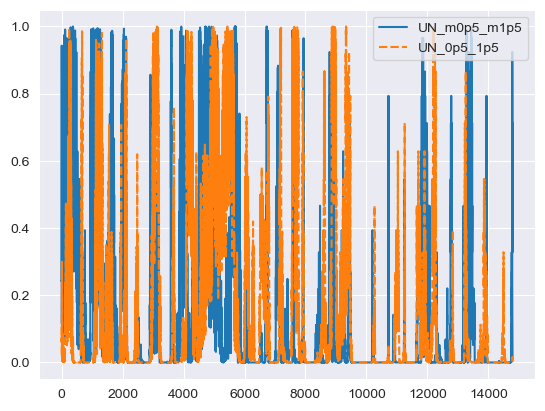

In [51]:
import seaborn as sns

sns.lineplot(data=ks_df.drop('Window_', axis=1), palette='tab10')

Outcasts for ('m0p5', 'm1p5'): 0
Outcasts for ('0p5', '1p5'): 0


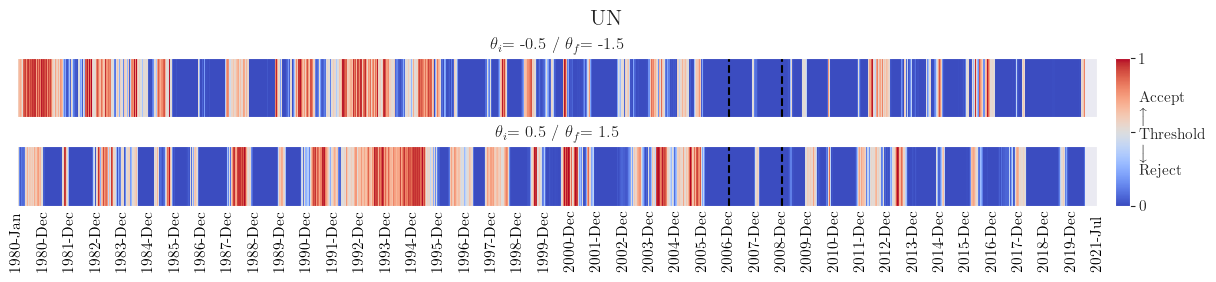

In [173]:
 # With a confidence level of 95%, we must reject the hypothesis that the distributions are the same if the p-value is less than 0.05
fig, errors = plot_rolling_pmesh(coefficients, actual_windows, p_values, latex=True, suptitle=market, ndays=NDAYS, label_spacing=365)

In [174]:
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_p_{NDAYS}days_variousthresholds_{VOL_LIMIT}.png', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_p_{NDAYS}days_variousthresholds_{VOL_LIMIT}.eps', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_p_{NDAYS}days_variousthresholds_{VOL_LIMIT}.pdf', bbox_inches='tight')

## UW

In [175]:
market = "UW"

In [176]:
regenerate = False
for t1_string, t2_string in coefficients:
    if not os.path.exists(f'../data/processed/dynamics/{market}_rolling_MFHT_peaks_{t1_string}_{t2_string}_200bins_{VOL_LIMIT}.pickle') or regenerate:
        print(f"Generating {market} with thresholds {t1_string}-{t2_string}")
        # Data must be regenerate
        df, outcasts = create_dataset([market], windows, t1_string, t2_string)
        print(f"There are {len(outcasts[market])} outcasts")
        # df['thresholds'] = f'{t1_string}_{t2_string}'
        df.to_pickle(f'../data/processed/dynamics/{market}_rolling_MFHT_peaks_{t1_string}_{t2_string}_200bins_{VOL_LIMIT}.pickle')
regenerate = False

In [177]:
p_values, stat_values, outcasts = test_mfhts(market, windows, NDAYS, coefficients, regenerate=False)
# print_rejections(p_values, windows, NDAYS, coefficients)

Outcasts for ('m0p5', 'm1p5'): 1055
Outcasts for ('0p5', '1p5'): 14


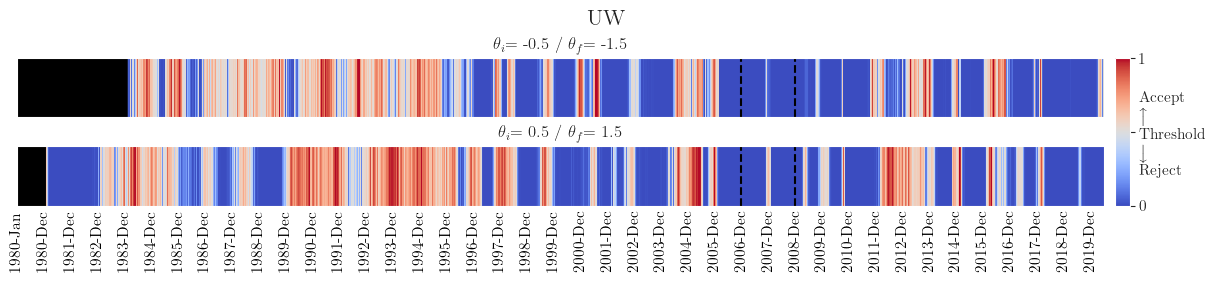

In [178]:
 # With a confidence level of 95%, we must reject the hypothesis that the distributions are the same if the p-value is less than 0.05
fig, errors = plot_rolling_pmesh(coefficients, actual_windows, p_values, latex=True, suptitle=market, ndays=NDAYS, label_spacing=365)

In [179]:
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_p_{NDAYS}days_variousthresholds_{VOL_LIMIT}.png', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_p_{NDAYS}days_variousthresholds_{VOL_LIMIT}.eps', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_p_{NDAYS}days_variousthresholds_{VOL_LIMIT}.pdf', bbox_inches='tight')

## LN

In [180]:
market = "LN"

In [181]:
regenerate = False
for t1_string, t2_string in coefficients:
        df = pd.DataFrame()
        if not os.path.exists(f'../data/processed/dynamics/{market}_rolling_MFHT_peaks_{t1_string}_{t2_string}_200bins_{VOL_LIMIT}.pickle') or regenerate:
            print(f"Generating {market} with thresholds {t1_string}-{t2_string}")
            # Data must be regenerate
            df, outcasts = create_dataset([market], windows, t1_string, t2_string)
            print(f"There are {len(outcasts[market])} outcasts")
            # df['thresholds'] = f'{t1_string}_{t2_string}'
            df.to_pickle(f'../data/processed/dynamics/{market}_rolling_MFHT_peaks_{t1_string}_{t2_string}_200bins_{VOL_LIMIT}.pickle')
regenerate = False

In [182]:
p_values, stat_values, outcasts = test_mfhts(market, windows, NDAYS, coefficients, regenerate=regenerate)
# print_rejections(p_values, windows, NDAYS, coefficients)

Outcasts for ('m0p5', 'm1p5'): 3077
Outcasts for ('0p5', '1p5'): 2121


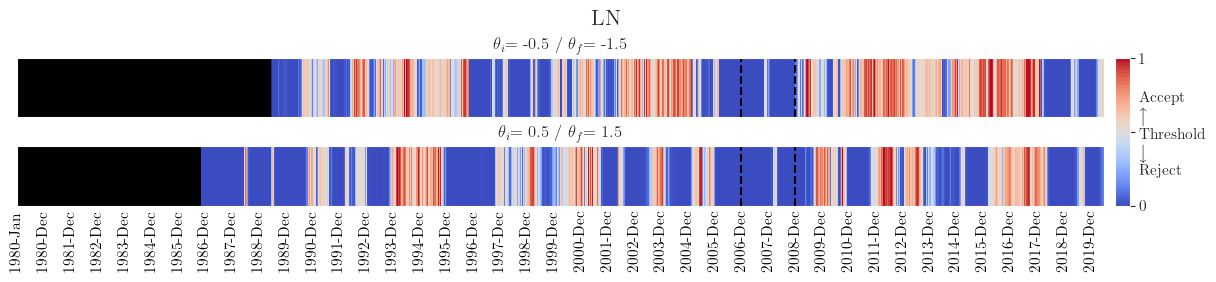

In [183]:
# With a confidence level of 95%, we must reject the hypothesis that the distributions are the same if the p-value is less than 0.05
fig, errors = plot_rolling_pmesh(coefficients, actual_windows, p_values, latex=True, suptitle=market, ndays=NDAYS, label_spacing=365)

In [184]:
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_p_{NDAYS}days_variousthresholds_{VOL_LIMIT}.png', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_p_{NDAYS}days_variousthresholds_{VOL_LIMIT}.eps', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_p_{NDAYS}days_variousthresholds_{VOL_LIMIT}.pdf', bbox_inches='tight')

## JT

In [185]:
market = "JT"

In [186]:
regenerate = False
for t1_string, t2_string in coefficients:
    df = pd.DataFrame()
    if not os.path.exists(f'../data/processed/dynamics/{market}_rolling_MFHT_peaks_{t1_string}_{t2_string}_200bins_{VOL_LIMIT}.pickle') or regenerate:
        print(f"Generating {market} with thresholds {t1_string}-{t2_string}")
        # Data must be regenerate
        df, outcasts = create_dataset([market], windows, t1_string, t2_string)
        print(f"There are {len(outcasts[market])} outcasts")
        # df['thresholds'] = f'{t1_string}_{t2_string}'
        df.to_pickle(f'../data/processed/dynamics/{market}_rolling_MFHT_peaks_{t1_string}_{t2_string}_200bins_{VOL_LIMIT}.pickle')
regenerate = False

In [187]:
p_values, stat_values, outcasts = test_mfhts(market, windows, NDAYS, coefficients, regenerate=regenerate)
# print_rejections(p_values, windows, NDAYS, coefficients)

Outcasts for ('m0p5', 'm1p5'): 0
Outcasts for ('0p5', '1p5'): 0


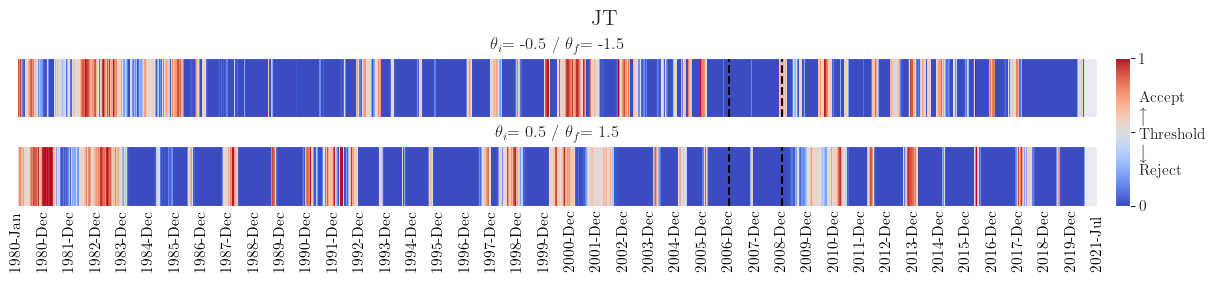

In [188]:
# With a confidence level of 95%, we must reject the hypothesis that the distributions are the same if the p-value is less than 0.05
fig, errors = plot_rolling_pmesh(coefficients, actual_windows, p_values, latex=True, suptitle=market, ndays=NDAYS, label_spacing=365)

In [189]:
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_p_{NDAYS}days_variousthresholds_{VOL_LIMIT}.png', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_p_{NDAYS}days_variousthresholds_{VOL_LIMIT}.eps', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_p_{NDAYS}days_variousthresholds_{VOL_LIMIT}.pdf', bbox_inches='tight')